## Import

In [1]:
# importing the libraries
import os
import pandas as pd
import numpy as np
from itertools import chain
from IPython.display import clear_output

# for reading and displaying images
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.models.model_util import load_model, save_checkpoint

# other files
from src.training.run import *
from src.data.data_util import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary

# Maintenance
import mlflow
from DeepNotion.build import *

## Load Configurations and set Seed

In [2]:
from src.config import *
cfg = load_config()

random_seed = cfg.seed
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## MLFlow Init

In [3]:
exp_name = '3dcnn_smri_comparison_test'
try:
    mlflow.create_experiment(name=exp_name)
except:
    print('Existing experiment')
    
mlflow.set_experiment(exp_name)

Existing experiment


## Tracking on Notion

In [4]:
cfg['notion']['use'] = False

### Load Preexisting page

In [6]:
if cfg['notion']['use']:
    root, client = login(cfg['notion'])
    page = root.children[-1]

### Make New Page

In [18]:
if cfg['notion']['use']:

    print(today())
    root, client = login(cfg['notion'])
    page = make_page(root)

    toggle = page.children.add_new(ToggleBlock, title='Configuration')

    print("Saving Configurations ...")
    for name, value in cfg.get_dict().items():
        if name not in ['notion']:
            txt = '**' + name + '** ' + str(value)
            print(txt)
            toggle.children.add_new(BulletedListBlock, title=txt)

#     fold_db = make_db(page, schema=cfg.schema)
#     test_db = make_db(page, schema=cfg.test_schema)

2021.02.08.20:14


## Train

### No Fold

In [4]:
#################################
### CHANGE CONFIGURATION HERE ###
#################################
cfg.model_name = 'resnet_no_maxpool'
cfg.start_channels = 64
cfg.registration = 'tlrc'
# cfg.learning_rate = 1e-5 # from checkpoint
#################################
cfg.refresh()
model, cfg.device = load_model(cfg.model_name, verbose=False, cfg=cfg)
print(cfg.device)

optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

trn_dp, tst_dp = DataPacket(), DataPacket()

run_date = today().replace('.', '_').replace(':', '') + '_' + cfg.model_name
condition = 'TLRC Aug, 100 ep, Resnet 64/128/256/512, no_maxpool'

mlflow.start_run(run_name=condition)

Model Resnet_no_maxpool is selected.
cuda:0


<ActiveRun: >

Epoch 1 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 154.5 sec [valid] 16.9 sec 
[TRAIN]:: Loss=3290.872 Mae=55.353 Rmse=57.249 Corr=0.533 
[TEST ]:: Loss=4152.482 Mae=62.803 Rmse=64.402 Corr=0.581 


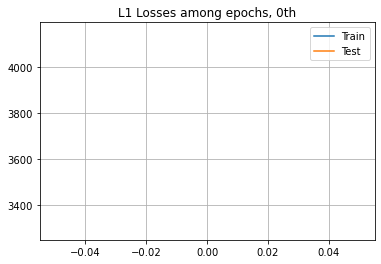

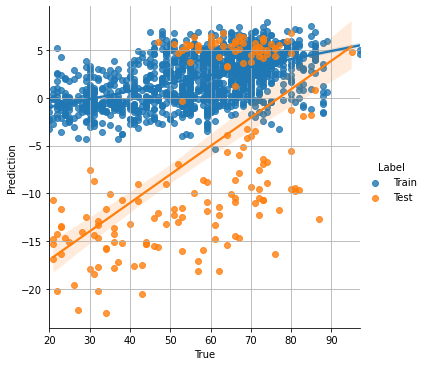

Saving ...
Epoch 2 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 140.0 sec [valid] 16.4 sec 
[TRAIN]:: Loss=2942.802 Mae=52.264 Rmse=54.128 Corr=0.645 
[TEST ]:: Loss=4343.813 Mae=64.178 Rmse=65.871 Corr=0.542 
Epoch 3 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 140.7 sec [valid] 16.3 sec 
[TRAIN]:: Loss=2631.825 Mae=49.286 Rmse=51.173 Corr=0.658 
[TEST ]:: Loss=3140.938 Mae=53.434 Rmse=55.982 Corr=0.498 
Epoch 4 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 141.0 sec [valid] 16.5 sec 
[TRAIN]:: Loss=2324.347 Mae=46.179 Rmse=48.073 Corr=0.674 
[TEST ]:: Loss=2647.569 Mae=47.838 Rmse=51.359 Corr=-0.647 
Epoch 5 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 140.2 sec [valid] 16.3 sec 
[TRAIN]:: Loss=2015.960 Mae=42.871 Rmse=44.749 Corr=0.691 
[TEST ]:: Loss=1977.635 Mae=39.090 Rmse=44.303 Corr=-0.585 
Epoch 6 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 139.6 sec [valid] 16.2 sec 
[TRAIN]:: Loss=1710.033 Mae=39.359 Rmse=41.184 Corr=0.715 
[TEST ]:: Loss=1577.928 Mae=34.009 Rmse=39.492 Corr=-0.587 


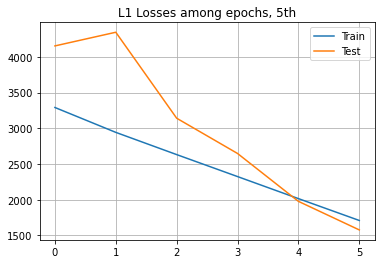

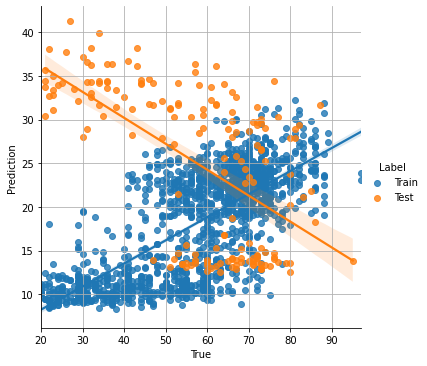

Saving ...
Epoch 7 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 139.8 sec [valid] 16.2 sec 
[TRAIN]:: Loss=1418.667 Mae=35.692 Rmse=37.482 Corr=0.735 
[TEST ]:: Loss=1448.658 Mae=32.706 Rmse=37.855 Corr=-0.639 
Epoch 8 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 141.2 sec [valid] 16.1 sec 
[TRAIN]:: Loss=1152.656 Mae=31.966 Rmse=33.743 Corr=0.757 
[TEST ]:: Loss=1458.159 Mae=34.582 Rmse=38.112 Corr=0.416 
Epoch 9 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 138.7 sec [valid] 16.2 sec 
[TRAIN]:: Loss=918.758 Mae=28.352 Rmse=30.079 Corr=0.784 
[TEST ]:: Loss=1312.358 Mae=32.521 Rmse=36.143 Corr=0.447 
Epoch 10 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 143.2 sec [valid] 16.2 sec 
[TRAIN]:: Loss=721.927 Mae=24.918 Rmse=26.608 Corr=0.810 
[TEST ]:: Loss=712.465 Mae=24.492 Rmse=26.582 Corr=0.802 
Epoch 11 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 139.9 sec [valid] 16.7 sec 
[TRAIN]:: Loss=554.459 Mae=21.674 Rmse=23.247 Corr=0.842 
[TEST ]:: Loss=732.821 Mae=24.565 Rmse=26.937 Corr=0.767 


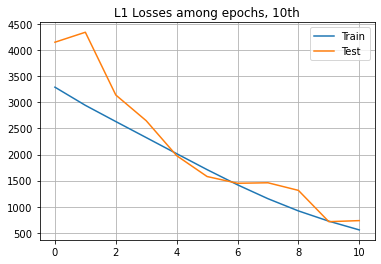

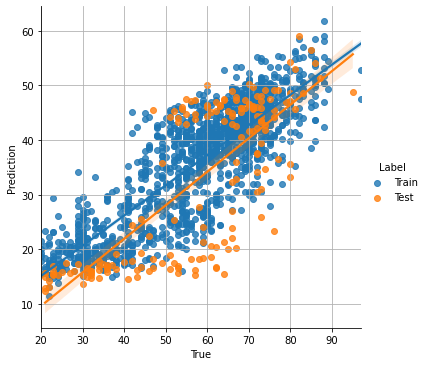

Saving ...
Epoch 12 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 145.1 sec [valid] 16.7 sec 
[TRAIN]:: Loss=421.803 Mae=18.759 Rmse=20.197 Corr=0.867 
[TEST ]:: Loss=341.435 Mae=16.000 Rmse=18.371 Corr=0.844 
Epoch 13 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 150.4 sec [valid] 18.6 sec 
[TRAIN]:: Loss=318.759 Mae=16.150 Rmse=17.471 Corr=0.882 
[TEST ]:: Loss=232.263 Mae=12.972 Rmse=15.076 Corr=0.783 
Epoch 14 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 158.6 sec [valid] 16.8 sec 
[TRAIN]:: Loss=232.491 Mae=13.619 Rmse=14.821 Corr=0.899 
[TEST ]:: Loss=238.715 Mae=13.263 Rmse=15.236 Corr=0.676 
Epoch 15 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 152.6 sec [valid] 17.9 sec 
[TRAIN]:: Loss=170.611 Mae=11.402 Rmse=12.606 Corr=0.906 
[TEST ]:: Loss=162.991 Mae=10.727 Rmse=12.566 Corr=0.801 
Epoch 16 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 146.2 sec [valid] 16.6 sec 
[TRAIN]:: Loss=125.976 Mae=9.592 Rmse=10.723 Corr=0.912 
[TEST ]:: Loss=162.249 Mae=11.001 Rmse=12.616 Corr=0.861 


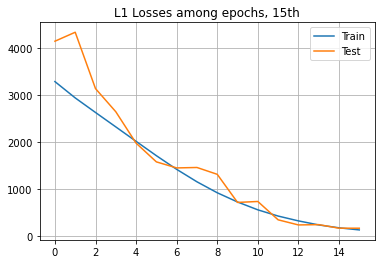

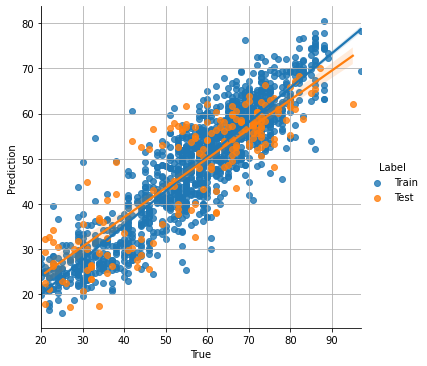

Saving ...
Epoch 17 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 154.2 sec [valid] 20.4 sec 
[TRAIN]:: Loss=95.395 Mae=8.168 Rmse=9.259 Corr=0.921 
[TEST ]:: Loss=180.520 Mae=11.351 Rmse=13.268 Corr=0.843 
Epoch 18 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 149.9 sec [valid] 18.6 sec 
[TRAIN]:: Loss=72.923 Mae=7.021 Rmse=8.078 Corr=0.927 
[TEST ]:: Loss=99.822 Mae=8.150 Rmse=9.841 Corr=0.842 
Epoch 19 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 153.6 sec [valid] 17.5 sec 
[TRAIN]:: Loss=57.853 Mae=6.133 Rmse=7.217 Corr=0.926 
[TEST ]:: Loss=165.382 Mae=10.082 Rmse=12.700 Corr=0.742 
Epoch 20 / 100 | BEST MAE 8.000 | LR 0.0001
[train] 143.4 sec [valid] 16.2 sec 
Saving ...
[TRAIN]:: Loss=49.922 Mae=5.581 Rmse=6.703 Corr=0.927 
[TEST ]:: Loss=88.658 Mae=7.607 Rmse=9.284 Corr=0.883 
Epoch 21 / 100 | BEST MAE 7.607 | LR 0.0001
[train] 147.2 sec [valid] 16.7 sec 
[TRAIN]:: Loss=42.755 Mae=5.157 Rmse=6.238 Corr=0.931 
[TEST ]:: Loss=88.696 Mae=7.662 Rmse=9.246 Corr=0.877 


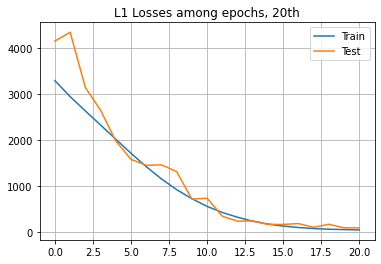

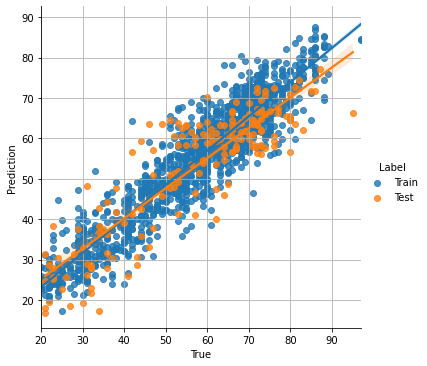

Saving ...
Epoch 22 / 100 | BEST MAE 7.607 | LR 0.0001
[train] 145.5 sec [valid] 16.8 sec 
[TRAIN]:: Loss=39.834 Mae=4.901 Rmse=6.010 Corr=0.930 
[TEST ]:: Loss=269.964 Mae=12.712 Rmse=16.242 Corr=0.567 
Epoch 23 / 100 | BEST MAE 7.607 | LR 0.0001
[train] 141.1 sec [valid] 16.1 sec 
[TRAIN]:: Loss=35.061 Mae=4.601 Rmse=5.647 Corr=0.936 
[TEST ]:: Loss=99.820 Mae=8.234 Rmse=9.893 Corr=0.839 
Epoch 24 / 100 | BEST MAE 7.607 | LR 0.0001
[train] 139.3 sec [valid] 16.4 sec 
Saving ...
[TRAIN]:: Loss=30.663 Mae=4.337 Rmse=5.271 Corr=0.943 
[TEST ]:: Loss=81.698 Mae=7.092 Rmse=8.999 Corr=0.860 
Epoch 25 / 100 | BEST MAE 7.092 | LR 0.0001
[train] 138.7 sec [valid] 16.1 sec 
Saving ...
[TRAIN]:: Loss=29.140 Mae=4.146 Rmse=5.119 Corr=0.945 
[TEST ]:: Loss=67.815 Mae=6.579 Rmse=8.134 Corr=0.887 
Epoch 26 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 139.0 sec [valid] 16.2 sec 
[TRAIN]:: Loss=29.191 Mae=4.188 Rmse=5.123 Corr=0.944 
[TEST ]:: Loss=77.238 Mae=7.030 Rmse=8.697 Corr=0.879 


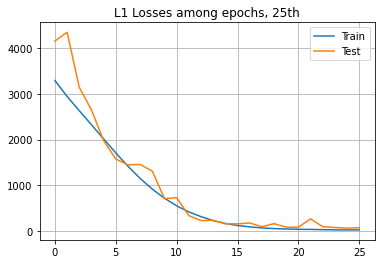

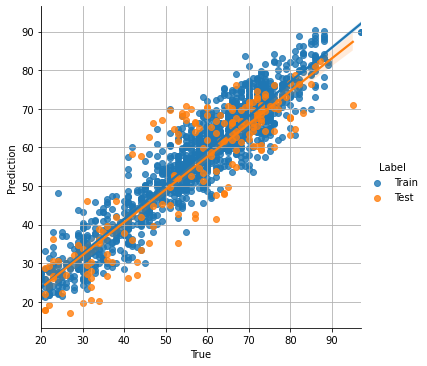

Saving ...
Epoch 27 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 138.6 sec [valid] 16.2 sec 
[TRAIN]:: Loss=27.606 Mae=4.071 Rmse=4.967 Corr=0.947 
[TEST ]:: Loss=82.934 Mae=7.312 Rmse=8.979 Corr=0.868 
Epoch 28 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 140.7 sec [valid] 16.8 sec 
[TRAIN]:: Loss=28.606 Mae=4.122 Rmse=5.082 Corr=0.945 
[TEST ]:: Loss=87.675 Mae=7.712 Rmse=9.228 Corr=0.869 
Epoch 29 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 136.2 sec [valid] 16.1 sec 
[TRAIN]:: Loss=28.251 Mae=4.100 Rmse=5.049 Corr=0.946 
[TEST ]:: Loss=81.107 Mae=7.186 Rmse=8.829 Corr=0.887 
Epoch 30 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 137.1 sec [valid] 17.1 sec 
[TRAIN]:: Loss=26.847 Mae=4.008 Rmse=4.874 Corr=0.948 
[TEST ]:: Loss=76.671 Mae=6.893 Rmse=8.603 Corr=0.879 
Epoch 31 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 135.9 sec [valid] 16.1 sec 
[TRAIN]:: Loss=26.492 Mae=3.983 Rmse=4.823 Corr=0.949 
[TEST ]:: Loss=88.261 Mae=7.474 Rmse=9.228 Corr=0.883 


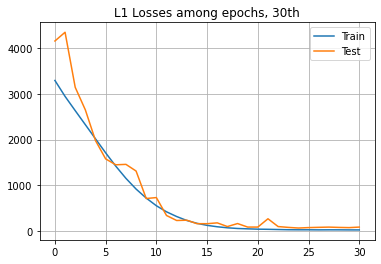

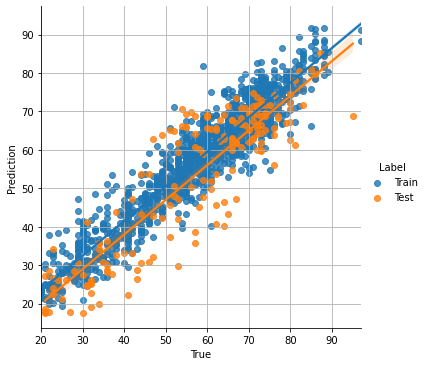

Saving ...
Epoch 32 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 136.9 sec [valid] 16.4 sec 
[TRAIN]:: Loss=26.928 Mae=3.969 Rmse=4.859 Corr=0.948 
[TEST ]:: Loss=171.829 Mae=10.647 Rmse=12.988 Corr=0.863 
Epoch 33 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 135.1 sec [valid] 16.2 sec 
[TRAIN]:: Loss=25.713 Mae=3.999 Rmse=4.803 Corr=0.951 
[TEST ]:: Loss=87.452 Mae=7.407 Rmse=9.272 Corr=0.869 
Epoch 34 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 137.0 sec [valid] 16.7 sec 
[TRAIN]:: Loss=24.674 Mae=3.910 Rmse=4.671 Corr=0.953 
[TEST ]:: Loss=75.082 Mae=6.804 Rmse=8.515 Corr=0.894 
Epoch 35 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 135.5 sec [valid] 16.1 sec 
[TRAIN]:: Loss=25.155 Mae=3.888 Rmse=4.726 Corr=0.952 
[TEST ]:: Loss=73.532 Mae=6.785 Rmse=8.476 Corr=0.888 
Epoch 36 / 100 | BEST MAE 6.579 | LR 0.0001
[train] 138.9 sec [valid] 16.9 sec 
Saving ...
[TRAIN]:: Loss=25.148 Mae=3.923 Rmse=4.729 Corr=0.952 
[TEST ]:: Loss=60.677 Mae=6.241 Rmse=7.686 Corr=0.898 


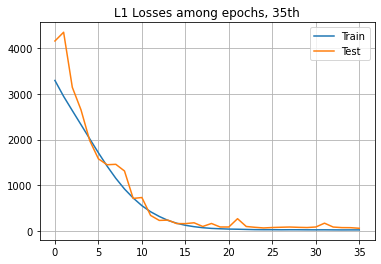

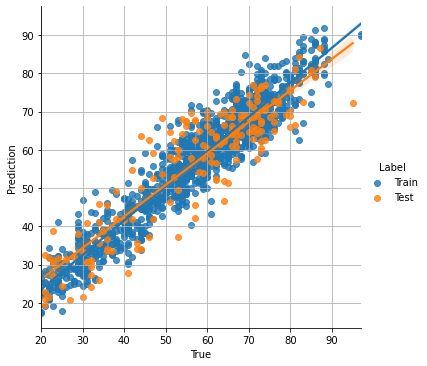

Saving ...
Epoch 37 / 100 | BEST MAE 6.241 | LR 0.0001


In [ ]:
# mlflow.start_run(run_name=condition)

fold = None
# cfg.epochs = 200
db = make_db(page, client=client, schema=cfg['notion']['no_fold_aug_schema'], title='Results') if cfg['notion']['use'] else None
for e in range(cfg.epochs):

    start_time = time.time()
    print(f'Epoch {e+1} / {cfg.epochs} | BEST MAE {cfg.best_mae:.3f} | LR {optimizer.param_groups[0]["lr"]}')

    model, trn_dp, trn_res = train(model, optimizer, fn_lst, trn_dp, cfg, fold=fold, augment=True)
    model, tst_dp, tst_res = valid(model, fn_lst, tst_dp, cfg, fold=fold)

    scheduler.step(tst_dp.mae[-1])
    elapsed_time = round(time.time() - start_time, 3)

    if cfg.best_mae > tst_dp.mae[-1]:

        cfg.best_mae = tst_dp.mae[-1]
        model_name = f'{cfg.model_name}_ep{e}-{cfg.epochs}_sd{cfg.seed}_mae{cfg.best_mae:.3f}.pth'
        save_checkpoint(model.state_dict(), model_name, model_dir=f'./result/models/{run_date}/', is_best=True)

    df = pd.concat([make_df(trn_res, 'Train'),
                    make_df(tst_res, 'Test')], ignore_index=True)

    trn_dp.corr.update(df[df['Label'] == 'Train'].corr().Prediction['True'])
    trn_dp.refresh()
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()

    if e % 1 == 0:
        trn_dp.info('train')
        tst_dp.info('test ')

    if e % cfg.verbose_period == 0:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(list(trn_dp.loss), label='Train')
        plt.plot(list(tst_dp.loss), label='Test')
        plt.grid(); plt.legend()

        sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()

        model_name = f'{cfg.model_name}_ep{e}-{str(cfg.epochs).zfill(3)}_sd{cfg.seed}_mae{cfg.best_mae:.3f}.pth'
        save_checkpoint(model.state_dict(), model_name, model_dir=f'./result/models/{run_date}/', is_best=False)

        if db:
            data = gather_data(e=e, time=elapsed_time, cfg=cfg,
                            train=trn_dp, valid=tst_dp)
            write_db(db, data)

    metrics = mlflow_data(time=elapsed_time, train=trn_dp, valid=tst_dp)
    mlflow.log_metrics(metrics, e)

    torch.cuda.empty_cache()

# Save Parameters to MLFlow
cfg.best_mae = min(tst_dp.mae)
cfg.refresh()
params = dict()
for name, value in cfg.get_dict().items():
    if name not in ['notion']:  
        params[name] = str(value)
mlflow.log_params(params)

save_checkpoint(cfg.get_dict(), 'cfg.pt', model_dir=f'./result/models/{run_date}/', is_best=True)

# Save Plots to MLFlow
sns.jointplot(data=df[df['Label'] == 'Test'], x='Prediction', y='True', kind='reg')
plt.grid()
plt.savefig(f'./result/models/{run_date}/test_jointplot.png')
plt.show()
# mlflow.log_artifact(f'./result/models/{run_date}/test_jointplot.png')
plt.close()

plt.title(f"L1 Losses\n{condition}")
plt.plot(list(trn_dp.loss), label='Train')
plt.plot(list(tst_dp.loss), label='Test')
plt.grid(); plt.legend()
plt.savefig(f'./result/models/{run_date}/loss_plot.png')
plt.show()
# mlflow.log_artifact(f'./result/models/{run_date}/loss_plot.png')

mlflow.end_run()

In [6]:
import yaml
cfg.best_mae = min(tst_dp.mae)
with open(f'./result/models/{run_date}/cfg.yml', 'w') as y:
    yaml.dump(cfg.get_dict(), y, default_flow_style=False)

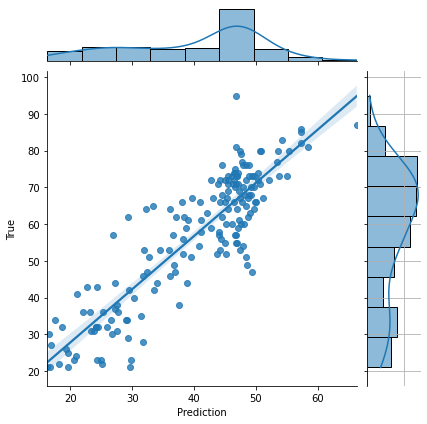

In [7]:
sns.jointplot(data=df[df['Label'] == 'Test'], x='Prediction', y='True', kind='reg')
plt.grid()

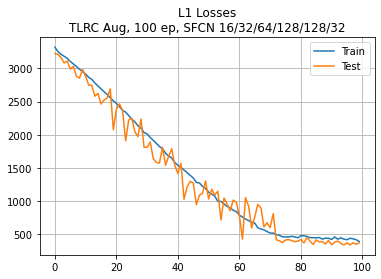

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다: 'G:\\My Drive'

In [8]:
plt.title(f"L1 Losses\n{condition}")
plt.plot(list(trn_dp.loss), label='Train')
plt.plot(list(tst_dp.loss), label='Test')
plt.grid(); plt.legend()
plt.savefig(f'./result/models/{run_date}/loss_plot.png')
plt.show()
mlflow.log_artifact(f'./result/models/{run_date}/loss_plot.png')

### Unexpected stops - checkpoint

Epoch 91 / 100, BEST MAE 6.499
[train] 191.1 sec [valid] 21.0 sec 
[TRAIN]:: Loss=5.907 Mae=1.783 Rmse=2.289 Corr=0.989 
[TEST ]:: Loss=69.431 Mae=6.616 Rmse=8.106 Corr=0.883 


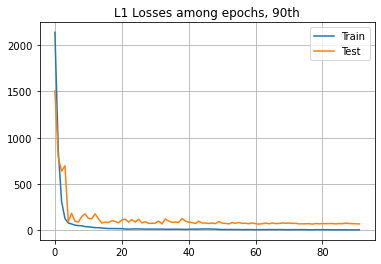

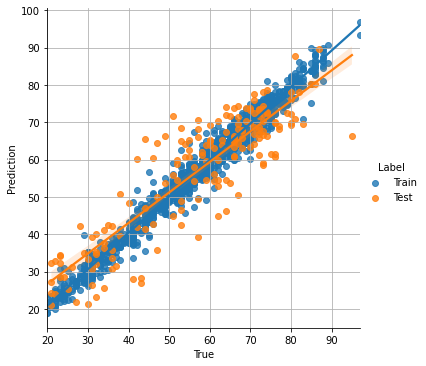

Saving ...


OSError: [WinError 433] A device which does not exist was specified: './result'

In [15]:
fold = None
# cfg.epochs = 200
db = make_db(page, client=client, schema=cfg['notion']['no_fold_aug_schema'], title='Results') if cfg['notion']['use'] else None
for e in range(e, cfg.epochs):
    
    start_time = time.time()
    print(f'Epoch {e+1} / {cfg.epochs}, BEST MAE {cfg.best_mae:.3f}')
    
    model, trn_dp, trn_res = train(model, optimizer, fn_lst, trn_dp, cfg, fold=fold, augment=True)
    model, tst_dp, tst_res = valid(model, fn_lst, tst_dp, cfg, fold=fold)
    elapsed_time = round(time.time() - start_time, 3)
       
    if cfg.best_mae > tst_dp.mae[-1]:
        
        cfg.best_mae = tst_dp.mae[-1]
        model_name = f'{cfg.model_name}_ep{e}-{cfg.epochs}_sd{cfg.seed}_mae{cfg.best_mae:.3f}.pth'
        save_checkpoint(model.state_dict(), model_name, model_dir=f'./result/models/{run_date}/', is_best=True)
        
    df = pd.concat([make_df(trn_res, 'Train'),
                    make_df(tst_res, 'Test')], ignore_index=True)
    
    trn_dp.corr.update(df[df['Label'] == 'Train'].corr().Prediction['True'])
    trn_dp.refresh()
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()

    if e % 1 == 0:
        trn_dp.info('train')
        tst_dp.info('test ')

    if e % cfg.verbose_period == 0:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(list(trn_dp.loss), label='Train')
        plt.plot(list(tst_dp.loss), label='Test')
        plt.grid(); plt.legend()

        sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()
        
        model_name = f'{cfg.model_name}_ep{e}-{str(cfg.epochs).zfill(3)}_sd{cfg.seed}_mae{cfg.best_mae:.3f}.pth'
        save_checkpoint(model.state_dict(), model_name, model_dir=f'./result/models/{run_date}/', is_best=False)
        
        if db:
            data = gather_data(e=e, time=elapsed_time, cfg=cfg,
                               train=trn_dp, valid=tst_dp)
            write_db(db, data)
    
    metrics = mlflow_data(time=elapsed_time, train=trn_dp, valid=tst_dp)
    mlflow.log_metrics(metrics, e)
    
    torch.cuda.empty_cache()
    
# Save Parameters to MLFlow
cfg.best_mae = min(tst_dp.mae)
cfg.refresh()
params = dict()
for name, value in cfg.get_dict().items():
    if name not in ['notion']:  
        params[name] = str(value)
mlflow.log_params(params)

save_checkpoint(cfg.get_dict(), 'cfg.pt', model_dir=f'./result/models/{run_date}/', is_best=True)

# Save Plots to MLFlow
sns.jointplot(data=df[df['Label'] == 'Test'], x='Prediction', y='True', kind='reg')
plt.grid()
plt.savefig(f'./result/models/{run_date}/test_jointplot.png')
plt.show()
# mlflow.log_artifact(f'./result/models/{run_date}/test_jointplot.png')
plt.close()

plt.title(f"L1 Losses\n{condition}")
plt.plot(list(trn_dp.loss), label='Train')
plt.plot(list(tst_dp.loss), label='Test')
plt.grid(); plt.legend()
plt.savefig(f'./result/models/{run_date}/loss_plot.png')
plt.show()
# mlflow.log_artifact(f'./result/models/{run_date}/loss_plot.png')

mlflow.end_run()

### kFold

In [8]:
models  = []
packets = []
tst_dp = DataPacket()

#### Whole Run

In [9]:
# test_db = make_db(page, client=client, schema=cfg['notion']['test_schema'], title='Test') if cfg['notion']['use'] else None
test_db = page.children[2]
fold_db = make_db(page, client=client, schema=cfg['notion']['schema'], title=f'Fold {fold+1}') if cfg['notion']['use'] else None

In [ ]:
for fold in range(16, cfg.folds):
    
    print(f'Fold {fold+1} / {cfg.folds}')
    mlflow.start_run(run_name=f'{today()} Fold {fold+1}')
    mlflow.log_params(params)
    mlflow.set_tags({
        'fold': fold+1
    })

    model, dps, res = run(cfg, fold, fold_db, mlflow=mlflow)
    models.append(model)
    packets.append(dps)
    
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=None)
    
    df = pd.concat([make_df(res[0], 'Train'),
                   make_df(res[1], 'Valid'),
                   make_df(tst_res, 'Test')], ignore_index=True)
    
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()
    
    # Show Holdout testset information
    tst_dp.info('Holdout test')
    sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if test_db:
        data = gather_data(f=fold, test=tst_dp)
        write_db(test_db, data)
    
    torch.cuda.empty_cache()
    clear_output(wait=True)

## Inference

In [8]:
dset = DatasetPlus(cfg, augment=False, test=True)
dataloader = DataLoader(dset, batch_size=cfg.batch_size)

device = cfg.device
model.eval()
predictions, targets = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device).squeeze()
        predictions.append(y_pred.cpu())
        targets.append(y.cpu())
torch.cuda.empty_cache()

predictions = torch.cat(predictions).detach().numpy()
targets = torch.cat(targets).detach().numpy()

In [15]:
results = pd.DataFrame([predictions, targets, dset.data_files], index=['predictions', 'targets', 'fname']).T

In [17]:
results['diff'] = results.targets - results.predictions

<AxesSubplot:>

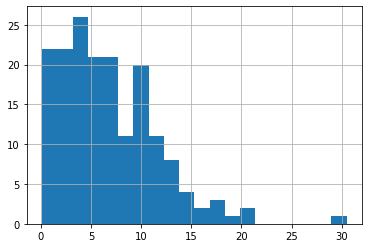

In [29]:
results['abs_diff'].hist(bins=20)

In [33]:
problematic = results[results['abs_diff'] > 10]

In [32]:
from utils.slice_viewer import *

In [36]:
sv = SliceViewer(problematic.iloc[0, 2])

In [ ]:
for fname in problematic.fname.values:
    
    SliceViewer(fname).triple_view()

## Ensemble

### Naive Averaging

In [39]:
# Ensemble
preds = dict()
models = glob('./models/ensembles/*.pth')
for fold, state in enumerate(models):
    
    model, device = load_model('resnet', verbose=False)
    model = torch.load(state)
    
    model, (_, _, _), tst_preds = eval(model, True, None, None, resize, device, batch_size,
                                      loss_fn, mae_fn, rmse_fn,
                                      [], [], [])
    
    preds[f'model_{fold}'] = list(map(float, tst_preds[1]))
    
ensemble_results = pd.DataFrame(preds)
ensemble_results['Avg'] = ensemble_results.mean(axis=1)
ensemble_results['True'] = list(map(float, tst_preds[0]))

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


In [64]:
def result_plot(df):
    
    avg = torch.Tensor(ensemble_results['Avg'])
    tru = torch.Tensor(ensemble_results['True'])
    
    corr = ensemble_results.corr()['True']['Avg']
    mae_fn, rmse_fn = nn.L1Loss(), RMSELoss()
    
    print(f'Ensemble Results')
    print(f'MAE  = {float(mae_fn(avg, tru)):.3f}')
    print(f'RMSE = {float(rmse_fn(avg, tru)):.3f}')
    print(f'CORR = {corr:.3f}')
    
    sns.lmplot(data=ensemble_results, x='True', y='Avg')
    plt.grid()
    plt.show()

Ensemble Results
MAE  = 7.025
RMSE = 8.598
CORR = 0.854


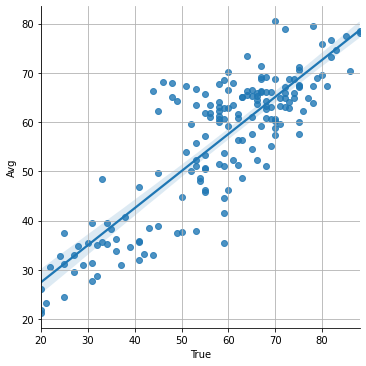

In [65]:
result_plot(ensemble_results)

### Blender

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
class CFG:
    
    model_name='resnet'
    dropout=0.1
    use_last_layer=True

In [10]:
class Ensemble(nn.Module):
    
    def __init__(self, model_list, CFG):
        super(Ensemble, self).__init__()
        
        self.cfg = CFG
        self.dropout = self.cfg.dropout
        self.models = dict()
        
        for idx, model_path in enumerate(model_list):
            
            model, device = load_model(self.cfg.model_name, verbose=False)
            model = torch.load(model_path)
            if not self.cfg.use_last_layer:
                model.fc = Identity()
                
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list) * 128, 128),
                    nn.Dropout(self.dropout),
                    nn.Linear(128, 1)
#                     nn.Dropout(self.dropout)
                )
                
            else:
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list), 1),
#                     nn.Dropout(self.dropout)
                )
                
            for param in model.parameters():
                param.requires_grad = False
                
            self.models[idx] = model
        
    def forward(self, x):
        
        vectors = list()
        for idx, model in self.models.items():
            vectors.append(model(x))
            
        x = torch.cat(vectors, dim=1)
        x = self.last_layer(x)
        
        return x

In [11]:
model_list = glob('./models/ensembles/rough/*.pth')
model_list.sort()
cfg = CFG()
cfg.use_last_layer = True
model = Ensemble(model_list, cfg).to(device)
with torch.no_grad():
    model.last_layer[0].weight.fill_(1 / len(model_list))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


## SFCN Test

In [53]:
resnet, _ = load_model('resnet', verbose=True)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

In [119]:
cfg.model_name = 'sfcn'
model, cfg.device = load_model(cfg.model_name, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

Model Sfcn is selected.


In [120]:
state_dict = torch.load('../UKBiobank_deep_pretrain/brain_age/run_20190719_00_epoch_best_mae.p')
state_dict = dict(state_dict)
keys = list(map(lambda x: x.split('module.')[-1], state_dict.keys()))
state_dict = {k: v for k, v in zip(keys, state_dict.values())}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [52]:
summary(model, input_size=(1, 160, 192, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 160, 192, 160]             896
       BatchNorm3d-2    [-1, 32, 160, 192, 160]              64
         MaxPool3d-3       [-1, 32, 80, 96, 80]               0
              ReLU-4       [-1, 32, 80, 96, 80]               0
            Conv3d-5       [-1, 64, 80, 96, 80]          55,360
       BatchNorm3d-6       [-1, 64, 80, 96, 80]             128
         MaxPool3d-7       [-1, 64, 40, 48, 40]               0
              ReLU-8       [-1, 64, 40, 48, 40]               0
            Conv3d-9      [-1, 128, 40, 48, 40]         221,312
      BatchNorm3d-10      [-1, 128, 40, 48, 40]             256
        MaxPool3d-11      [-1, 128, 20, 24, 20]               0
             ReLU-12      [-1, 128, 20, 24, 20]               0
           Conv3d-13      [-1, 256, 20, 24, 20]         884,992
      BatchNorm3d-14      [-1, 256, 20,

In [122]:
cfg.test = True
test_dset = MyDataset(cfg, augment=False, fold=None)
test_dl = DataLoader(test_dset, batch_size=16)

In [123]:
from tqdm import tqdm

In [124]:
mae = nn.L1Loss()

In [125]:
len(test_dl)

175

In [141]:
model.to(cfg.device)
model.eval()
y_preds, ys = [], []
age_bins = torch.tensor([42+i for i in range(40)])
with torch.no_grad(): # to not give loads on GPU... :(
    for i, (x, y) in tqdm(enumerate(test_dl)):

        x, y = F.interpolate(x, size=(160, 192, 160)).to(cfg.device), y.to(cfg.device)

        y_pred = model.forward(x)[0].to(cfg.device)
        y_pred = (np.exp(y_pred.squeeze().cpu()) * age_bins).sum()
#         y_pred = y_pred.max(axis=1).indices.squeeze()
#         y_pred += 42
        y_preds.append(y_pred)
        ys.append(y.squeeze())
#             loss = mae(y_pred, y.squeeze())


torch.cuda.empty_cache()

175it [01:34,  1.85it/s]
